### 💾 Drive Bağlantısı

Google Drive'ı Colab'a bağlayıp çalışma dizinini `MyDrive` olarak ayarlar:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


### 📂 Dizin Hazırlığı ve Proje Klonlama

Bu bölümde, Google Drive'da çalışılacak klasöre geçiş yapılır ve gerekli proje GitHub üzerinden klonlanır.

- `cd` komutları ile istenilen dizinlere geçiş yapılır.
- `ls -al` komutu ile dizin içeriği görüntülenir.
- `git clone` komutu kullanılarak GitHub üzerindeki proje yerel ortama indirilir.

Bu işlemler, proje dosyalarına erişim sağlamak ve çalışmaya başlamak için ortamı hazırlar.

In [2]:
cd efficient_ad/

/content/drive/MyDrive/efficient_ad


In [3]:
ls -al

total 3661
-rw------- 1 root root 3743815 Apr 22 15:31 efficientad.ipynb
drwx------ 2 root root    4096 Apr 22 15:24 mvtec_anomaly_detection/


In [4]:
!git clone https://github.com/nelson1425/EfficientAD.git

Cloning into 'EfficientAD'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 37 (delta 12), reused 9 (delta 9), pack-reused 17 (from 1)
Receiving objects: 100% (37/37), 37.98 MiB | 17.49 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [5]:
cd EfficientAD/

/content/drive/MyDrive/efficient_ad/EfficientAD


In [6]:
!mv /content/drive/MyDrive/efficient_ad/mvtec_anomaly_detection/ /content/drive/MyDrive/efficient_ad/EfficientAD/

### 📦 Gerekli Kütüphanelerin Kurulumu ve Kontrolü

Bu bölümde, proje için ihtiyaç duyulan Python kütüphaneleri yüklenir ve sistemde yüklü olan paketler kontrol edilir

In [7]:
pip install tifffile tqdm scikit-learn numpy Pillow scipy tabulate


In [8]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.5.2
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.3.2
alabaster                             1.0.0
albucore                              0.0.23
albumentations                        2.0.5
ale-py                                0.10.2
altair                                5.5.0
annotated-types                       0.7.0
anyio                                 4.9.0
argon2-cffi                           23.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.1
arviz                                 0.21.0
astropy                               7.0.1
astropy-iers-data                     0.2025.4.14.0.37.22
astunparse                            1.6.3
atpublic                              5

### 🧠 EfficientAD - MVTec AD (Wood Alt Kümesi) Eğitim Açıklaması

Bu komut, MVTec Anomaly Detection veri setinin wood (ahşap) alt veri kümesi üzerinde bir anomalilik tespit modeli eğitir.

### 🧠 Modelin Yapısı
- **Teacher Model (donmuş)**: Önceden eğitilmiş ve referans olarak kullanılır.

- **Student Model**: Öğretmeni taklit etmeye çalışır.

- **Autoencoder**: Öğretmen ve öğrencinin çıktılarıyla çalışır, farkları öğrenir.

### ⚙️ Eğitim Parametreleri
- **Epoch**: 1000 adım (varsayılan)

- **Learning Rate**: 5e-4

- **Batch Size**: 12

### 📦 Çıktılar

- **Eğitim sonrası modeller**: teacher_final.pth, student_final.pth, autoencoder_final.pth

- Anomali haritaları .tiff formatında kaydedilir.

- Performans **ROC AUC değeri** ile ölçülür.





### Overwriting efficientad.py

In [39]:
# %load efficientad.py
%%writefile efficientad.py
#!/usr/bin/python
import numpy as np
import tifffile
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import argparse
import itertools
import os
import random
from tqdm import tqdm
from common import get_autoencoder, get_pdn_small, get_pdn_medium, \
    ImageFolderWithoutTarget, ImageFolderWithPath, InfiniteDataloader
from sklearn.metrics import roc_auc_score

import cv2
import matplotlib.pyplot as plt

def get_argparse():
    parser = argparse.ArgumentParser()
    parser.add_argument('-d', '--dataset', default='mvtec_ad',
                        choices=['mvtec_ad', 'mvtec_loco'])
    parser.add_argument('-s', '--subdataset', default='wood',
                        help='One of 15 sub-datasets of Mvtec AD or 5' +
                             'sub-datasets of Mvtec LOCO')
    parser.add_argument('-o', '--output_dir', default='output/1')
    parser.add_argument('-m', '--model_size', default='small',
                        choices=['small', 'medium'])
    parser.add_argument('-w', '--weights', default='models/teacher_small.pth')
    parser.add_argument('-i', '--imagenet_train_path',
                        default='none',
                        help='Set to "none" to disable ImageNet' +
                             'pretraining penalty. Or see README.md to' +
                             'download ImageNet and set to ImageNet path')
    parser.add_argument('-a', '--mvtec_ad_path',
                        default='./mvtec_anomaly_detection',
                        help='Downloaded Mvtec AD dataset')
    parser.add_argument('-b', '--mvtec_loco_path',
                        default='./mvtec_loco_anomaly_detection',
                        help='Downloaded Mvtec LOCO dataset')
    parser.add_argument('-t', '--train_steps', type=int, default=70000)
    return parser.parse_args()

# constants
seed = 42
on_gpu = torch.cuda.is_available()
out_channels = 384
image_size = 256

# data loading
default_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_ae = transforms.RandomChoice([
    transforms.ColorJitter(brightness=0.2),
    transforms.ColorJitter(contrast=0.2),
    transforms.ColorJitter(saturation=0.2)
])

def train_transform(image):
    return default_transform(image), default_transform(transform_ae(image))

def main():
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    config = get_argparse()

    if config.dataset == 'mvtec_ad':
        dataset_path = config.mvtec_ad_path
    elif config.dataset == 'mvtec_loco':
        dataset_path = config.mvtec_loco_path
    else:
        raise Exception('Unknown config.dataset')

    pretrain_penalty = True
    if config.imagenet_train_path == 'none':
        pretrain_penalty = False

    # create output dir
    train_output_dir = os.path.join(config.output_dir, 'trainings',
                                    config.dataset, config.subdataset)
    test_output_dir = os.path.join(config.output_dir, 'anomaly_maps',
                                   config.dataset, config.subdataset, 'test')
    os.makedirs(train_output_dir)
    os.makedirs(test_output_dir)

    # load data
    full_train_set = ImageFolderWithoutTarget(
        os.path.join(dataset_path, config.subdataset, 'train'),
        transform=transforms.Lambda(train_transform))
    test_set = ImageFolderWithPath(
        os.path.join(dataset_path, config.subdataset, 'test'))
    if config.dataset == 'mvtec_ad':
        # mvtec dataset paper recommend 10% validation set
        train_size = int(0.9 * len(full_train_set))
        validation_size = len(full_train_set) - train_size
        rng = torch.Generator().manual_seed(seed)
        train_set, validation_set = torch.utils.data.random_split(full_train_set,
                                                           [train_size,
                                                            validation_size],
                                                           rng)
    elif config.dataset == 'mvtec_loco':
        train_set = full_train_set
        validation_set = ImageFolderWithoutTarget(
            os.path.join(dataset_path, config.subdataset, 'validation'),
            transform=transforms.Lambda(train_transform))
    else:
        raise Exception('Unknown config.dataset')

    # hyperparameter configurations
    batchsize = 1
    numworkers = 4
    learningrate = 3e-4
    weightdecay = 1e-5

    train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True,
                              num_workers=numworkers, pin_memory=True)
    train_loader_infinite = InfiniteDataloader(train_loader)
    validation_loader = DataLoader(validation_set, batch_size=1)

    if pretrain_penalty:
        # load pretraining data for penalty
        penalty_transform = transforms.Compose([
            transforms.Resize((2 * image_size, 2 * image_size)),
            transforms.RandomGrayscale(0.3),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224,
                                                                  0.225])
        ])
        penalty_set = ImageFolderWithoutTarget(config.imagenet_train_path,
                                               transform=penalty_transform)
        penalty_loader = DataLoader(penalty_set, batch_size=1, shuffle=True,
                                    num_workers=4, pin_memory=True)
        penalty_loader_infinite = InfiniteDataloader(penalty_loader)
    else:
        penalty_loader_infinite = itertools.repeat(None)

    # create models
    if config.model_size == 'small':
        teacher = get_pdn_small(out_channels)
        student = get_pdn_small(2 * out_channels)
    elif config.model_size == 'medium':
        teacher = get_pdn_medium(out_channels)
        student = get_pdn_medium(2 * out_channels)
    else:
        raise Exception()
    state_dict = torch.load(config.weights, map_location='cpu')
    teacher.load_state_dict(state_dict)
    autoencoder = get_autoencoder(out_channels)

    # teacher frozen
    teacher.eval()
    student.train()
    autoencoder.train()

    if on_gpu:
        teacher.cuda()
        student.cuda()
        autoencoder.cuda()

    teacher_mean, teacher_std = teacher_normalization(teacher, train_loader)


    optimizer = torch.optim.Adam(itertools.chain(student.parameters(),
                                                 autoencoder.parameters()),
                                 lr=learningrate, weight_decay=weightdecay)
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=int(0.95 * config.train_steps), gamma=0.1)
    tqdm_obj = tqdm(range(config.train_steps))
    for iteration, (image_st, image_ae), image_penalty in zip(
            tqdm_obj, train_loader_infinite, penalty_loader_infinite):
        if on_gpu:
            image_st = image_st.cuda()
            image_ae = image_ae.cuda()
            if image_penalty is not None:
                image_penalty = image_penalty.cuda()
        with torch.no_grad():
            teacher_output_st = teacher(image_st)
            teacher_output_st = (teacher_output_st - teacher_mean) / teacher_std
        student_output_st = student(image_st)[:, :out_channels]
        distance_st = (teacher_output_st - student_output_st) ** 2
        d_hard = torch.quantile(distance_st, q=0.999)
        loss_hard = torch.mean(distance_st[distance_st >= d_hard])

        if image_penalty is not None:
            student_output_penalty = student(image_penalty)[:, :out_channels]
            loss_penalty = torch.mean(student_output_penalty**2)
            loss_st = loss_hard + loss_penalty
        else:
            loss_st = loss_hard

        ae_output = autoencoder(image_ae)
        with torch.no_grad():
            teacher_output_ae = teacher(image_ae)
            teacher_output_ae = (teacher_output_ae - teacher_mean) / teacher_std
        student_output_ae = student(image_ae)[:, out_channels:]
        distance_ae = (teacher_output_ae - ae_output)**2
        distance_stae = (ae_output - student_output_ae)**2
        loss_ae = torch.mean(distance_ae)
        loss_stae = torch.mean(distance_stae)
        loss_total = loss_st + loss_ae + loss_stae

        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        scheduler.step()

        if iteration % 10 == 0:
            tqdm_obj.set_description(
                "Current loss: {:.4f}  ".format(loss_total.item()))

        if iteration % 1000 == 0:
            torch.save(teacher, os.path.join(train_output_dir,
                                             'teacher_tmp.pth'))
            torch.save(student, os.path.join(train_output_dir,
                                             'student_tmp.pth'))
            torch.save(autoencoder, os.path.join(train_output_dir,
                                                 'autoencoder_tmp.pth'))

        if iteration % 10000 == 0 and iteration > 0:
            # run intermediate evaluation
            teacher.eval()
            student.eval()
            autoencoder.eval()

            q_st_start, q_st_end, q_ae_start, q_ae_end = map_normalization(
                validation_loader=validation_loader, teacher=teacher,
                student=student, autoencoder=autoencoder,
                teacher_mean=teacher_mean, teacher_std=teacher_std,
                desc='Intermediate map normalization')
            auc = test(
                test_set=test_set, teacher=teacher, student=student,
                autoencoder=autoencoder, teacher_mean=teacher_mean,
                teacher_std=teacher_std, q_st_start=q_st_start,
                q_st_end=q_st_end, q_ae_start=q_ae_start, q_ae_end=q_ae_end,
                test_output_dir=None, desc='Intermediate inference')
            print('Intermediate image auc: {:.4f}'.format(auc))

            # teacher frozen
            teacher.eval()
            student.train()
            autoencoder.train()

    teacher.eval()
    student.eval()
    autoencoder.eval()

    torch.save(teacher, os.path.join(train_output_dir, 'teacher_final.pth'))
    torch.save(student, os.path.join(train_output_dir, 'student_final.pth'))
    torch.save(autoencoder, os.path.join(train_output_dir,
                                         'autoencoder_final.pth'))

    q_st_start, q_st_end, q_ae_start, q_ae_end = map_normalization(
        validation_loader=validation_loader, teacher=teacher, student=student,
        autoencoder=autoencoder, teacher_mean=teacher_mean,
        teacher_std=teacher_std, desc='Final map normalization')
    auc = test(
        test_set=test_set, teacher=teacher, student=student,
        autoencoder=autoencoder, teacher_mean=teacher_mean,
        teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
        q_ae_start=q_ae_start, q_ae_end=q_ae_end,
        test_output_dir=test_output_dir, desc='Final inference')
    print('Final image auc: {:.4f}'.format(auc))

def save_anomaly_overlay(original_image_path, anomaly_map, save_path):
    original = cv2.imread(original_image_path)
    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    original = cv2.resize(original, (256, 256))

    min_val = np.min(anomaly_map)
    max_val = np.max(anomaly_map)
    if max_val - min_val > 0:
        anomaly_map_norm = (anomaly_map - min_val) / (max_val - min_val)
    else:
        anomaly_map_norm = np.zeros_like(anomaly_map)

    heatmap = cv2.applyColorMap(np.uint8(255 * anomaly_map_norm), cv2.COLORMAP_JET)

    # ✅ Kanal ve boyut uyumu kontrolü
    if heatmap.shape != original.shape:
        heatmap = cv2.resize(heatmap, (original.shape[1], original.shape[0]))

    overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))


def test(test_set, teacher, student, autoencoder, teacher_mean, teacher_std,
         q_st_start, q_st_end, q_ae_start, q_ae_end, test_output_dir=None,
         desc='Running inference'):
    y_true = []
    y_score = []
    for image, target, path in tqdm(test_set, desc=desc):
        orig_width = image.width
        orig_height = image.height
        image = default_transform(image)
        image = image[None]
        if on_gpu:
            image = image.cuda()
        map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std, q_st_start=q_st_start, q_st_end=q_st_end,
            q_ae_start=q_ae_start, q_ae_end=q_ae_end)
        map_combined = torch.nn.functional.pad(map_combined, (4, 4, 4, 4))
        map_combined = torch.nn.functional.interpolate(
            map_combined, (orig_height, orig_width), mode='bilinear')
        map_combined = map_combined[0, 0].cpu().numpy()

        defect_class = os.path.basename(os.path.dirname(path))
        if test_output_dir is not None:
            img_nm = os.path.split(path)[1].split('.')[0]
            if not os.path.exists(os.path.join(test_output_dir, defect_class)):
                os.makedirs(os.path.join(test_output_dir, defect_class))
            file = os.path.join(test_output_dir, defect_class, img_nm + '.tiff')
            tifffile.imwrite(file, map_combined)

            original_image_path = path  # test set'teki orijinal resim yolu
            overlay_save_path = os.path.join(test_output_dir, defect_class, img_nm + '_overlay.png')
            save_anomaly_overlay(original_image_path, map_combined, overlay_save_path)

        y_true_image = 0 if defect_class == 'good' else 1
        y_score_image = np.max(map_combined)
        y_true.append(y_true_image)
        y_score.append(y_score_image)
    auc = roc_auc_score(y_true=y_true, y_score=y_score)
    return auc * 100

@torch.no_grad()
def predict(image, teacher, student, autoencoder, teacher_mean, teacher_std,
            q_st_start=None, q_st_end=None, q_ae_start=None, q_ae_end=None):
    teacher_output = teacher(image)
    teacher_output = (teacher_output - teacher_mean) / teacher_std
    student_output = student(image)
    autoencoder_output = autoencoder(image)
    map_st = torch.mean((teacher_output - student_output[:, :out_channels])**2,
                        dim=1, keepdim=True)
    map_ae = torch.mean((autoencoder_output -
                         student_output[:, out_channels:])**2,
                        dim=1, keepdim=True)
    if q_st_start is not None:
        map_st = 0.1 * (map_st - q_st_start) / (q_st_end - q_st_start)
    if q_ae_start is not None:
        map_ae = 0.1 * (map_ae - q_ae_start) / (q_ae_end - q_ae_start)
    map_combined = 0.5 * map_st + 0.5 * map_ae
    return map_combined, map_st, map_ae

@torch.no_grad()
def map_normalization(validation_loader, teacher, student, autoencoder,
                      teacher_mean, teacher_std, desc='Map normalization'):
    maps_st = []
    maps_ae = []
    # ignore augmented ae image
    for image, _ in tqdm(validation_loader, desc=desc):
        if on_gpu:
            image = image.cuda()
        map_combined, map_st, map_ae = predict(
            image=image, teacher=teacher, student=student,
            autoencoder=autoencoder, teacher_mean=teacher_mean,
            teacher_std=teacher_std)
        maps_st.append(map_st)
        maps_ae.append(map_ae)
    maps_st = torch.cat(maps_st)
    maps_ae = torch.cat(maps_ae)
    q_st_start = torch.quantile(maps_st, q=0.9)
    q_st_end = torch.quantile(maps_st, q=0.995)
    q_ae_start = torch.quantile(maps_ae, q=0.9)
    q_ae_end = torch.quantile(maps_ae, q=0.995)
    return q_st_start, q_st_end, q_ae_start, q_ae_end

@torch.no_grad()
def teacher_normalization(teacher, train_loader):

    mean_outputs = []
    for train_image, _ in tqdm(train_loader, desc='Computing mean of features'):
        if on_gpu:
            train_image = train_image.cuda()
        teacher_output = teacher(train_image)
        mean_output = torch.mean(teacher_output, dim=[0, 2, 3])
        mean_outputs.append(mean_output)
    channel_mean = torch.mean(torch.stack(mean_outputs), dim=0)
    channel_mean = channel_mean[None, :, None, None]

    mean_distances = []
    for train_image, _ in tqdm(train_loader, desc='Computing std of features'):
        if on_gpu:
            train_image = train_image.cuda()
        teacher_output = teacher(train_image)
        distance = (teacher_output - channel_mean) ** 2
        mean_distance = torch.mean(distance, dim=[0, 2, 3])
        mean_distances.append(mean_distance)
    channel_var = torch.mean(torch.stack(mean_distances), dim=0)
    channel_var = channel_var[None, :, None, None]
    channel_std = torch.sqrt(channel_var)

    return channel_mean, channel_std

if __name__ == '__main__':
    main()


Overwriting efficientad.py


In [40]:
rm -rf output

In [41]:
!python efficientad.py --dataset mvtec_ad --subdataset wood --train_steps 6000

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Computing mean of features: 100% 63/63 [00:06<00:00, 10.28it/s]
Computing std of features: 100% 63/63 [00:05<00:00, 10.74it/s]
Current loss: 5.9267  : 100% 6000/6000 [16:30<00:00,  6.06it/s]
Final map normalization: 100% 7/7 [00:00<00:00,  7.33it/s]
Final inference: 100% 141/141 [00:32<00:00,  4.36it/s]
Final image auc: 89.6579


In [ ]:
!ls -al

total 79
-rw------- 1 root root  2715 Mar 21 19:54 benchmark.py
-rw------- 1 root root  4811 Mar 21 18:41 common.py
-rw------- 1 root root 15699 Mar 21 20:01 efficientad.py
drwx------ 2 root root  4096 Mar 21 18:41 .git
-rw------- 1 root root 11357 Mar 21 18:41 LICENSE
drwx------ 2 root root  4096 Mar 21 18:41 models
drwx------ 3 root root  4096 Mar 21 18:45 mvtec_anomaly_detection
drwx------ 3 root root  4096 Mar 21 19:02 output
-rw------- 1 root root 15119 Mar 21 19:56 pretraining.py
drwx------ 2 root root  4096 Mar 21 19:02 __pycache__
-rw------- 1 root root  4882 Mar 21 18:41 README.md
drwx------ 2 root root  4096 Mar 21 18:41 results


In [ ]:
rm -rf output

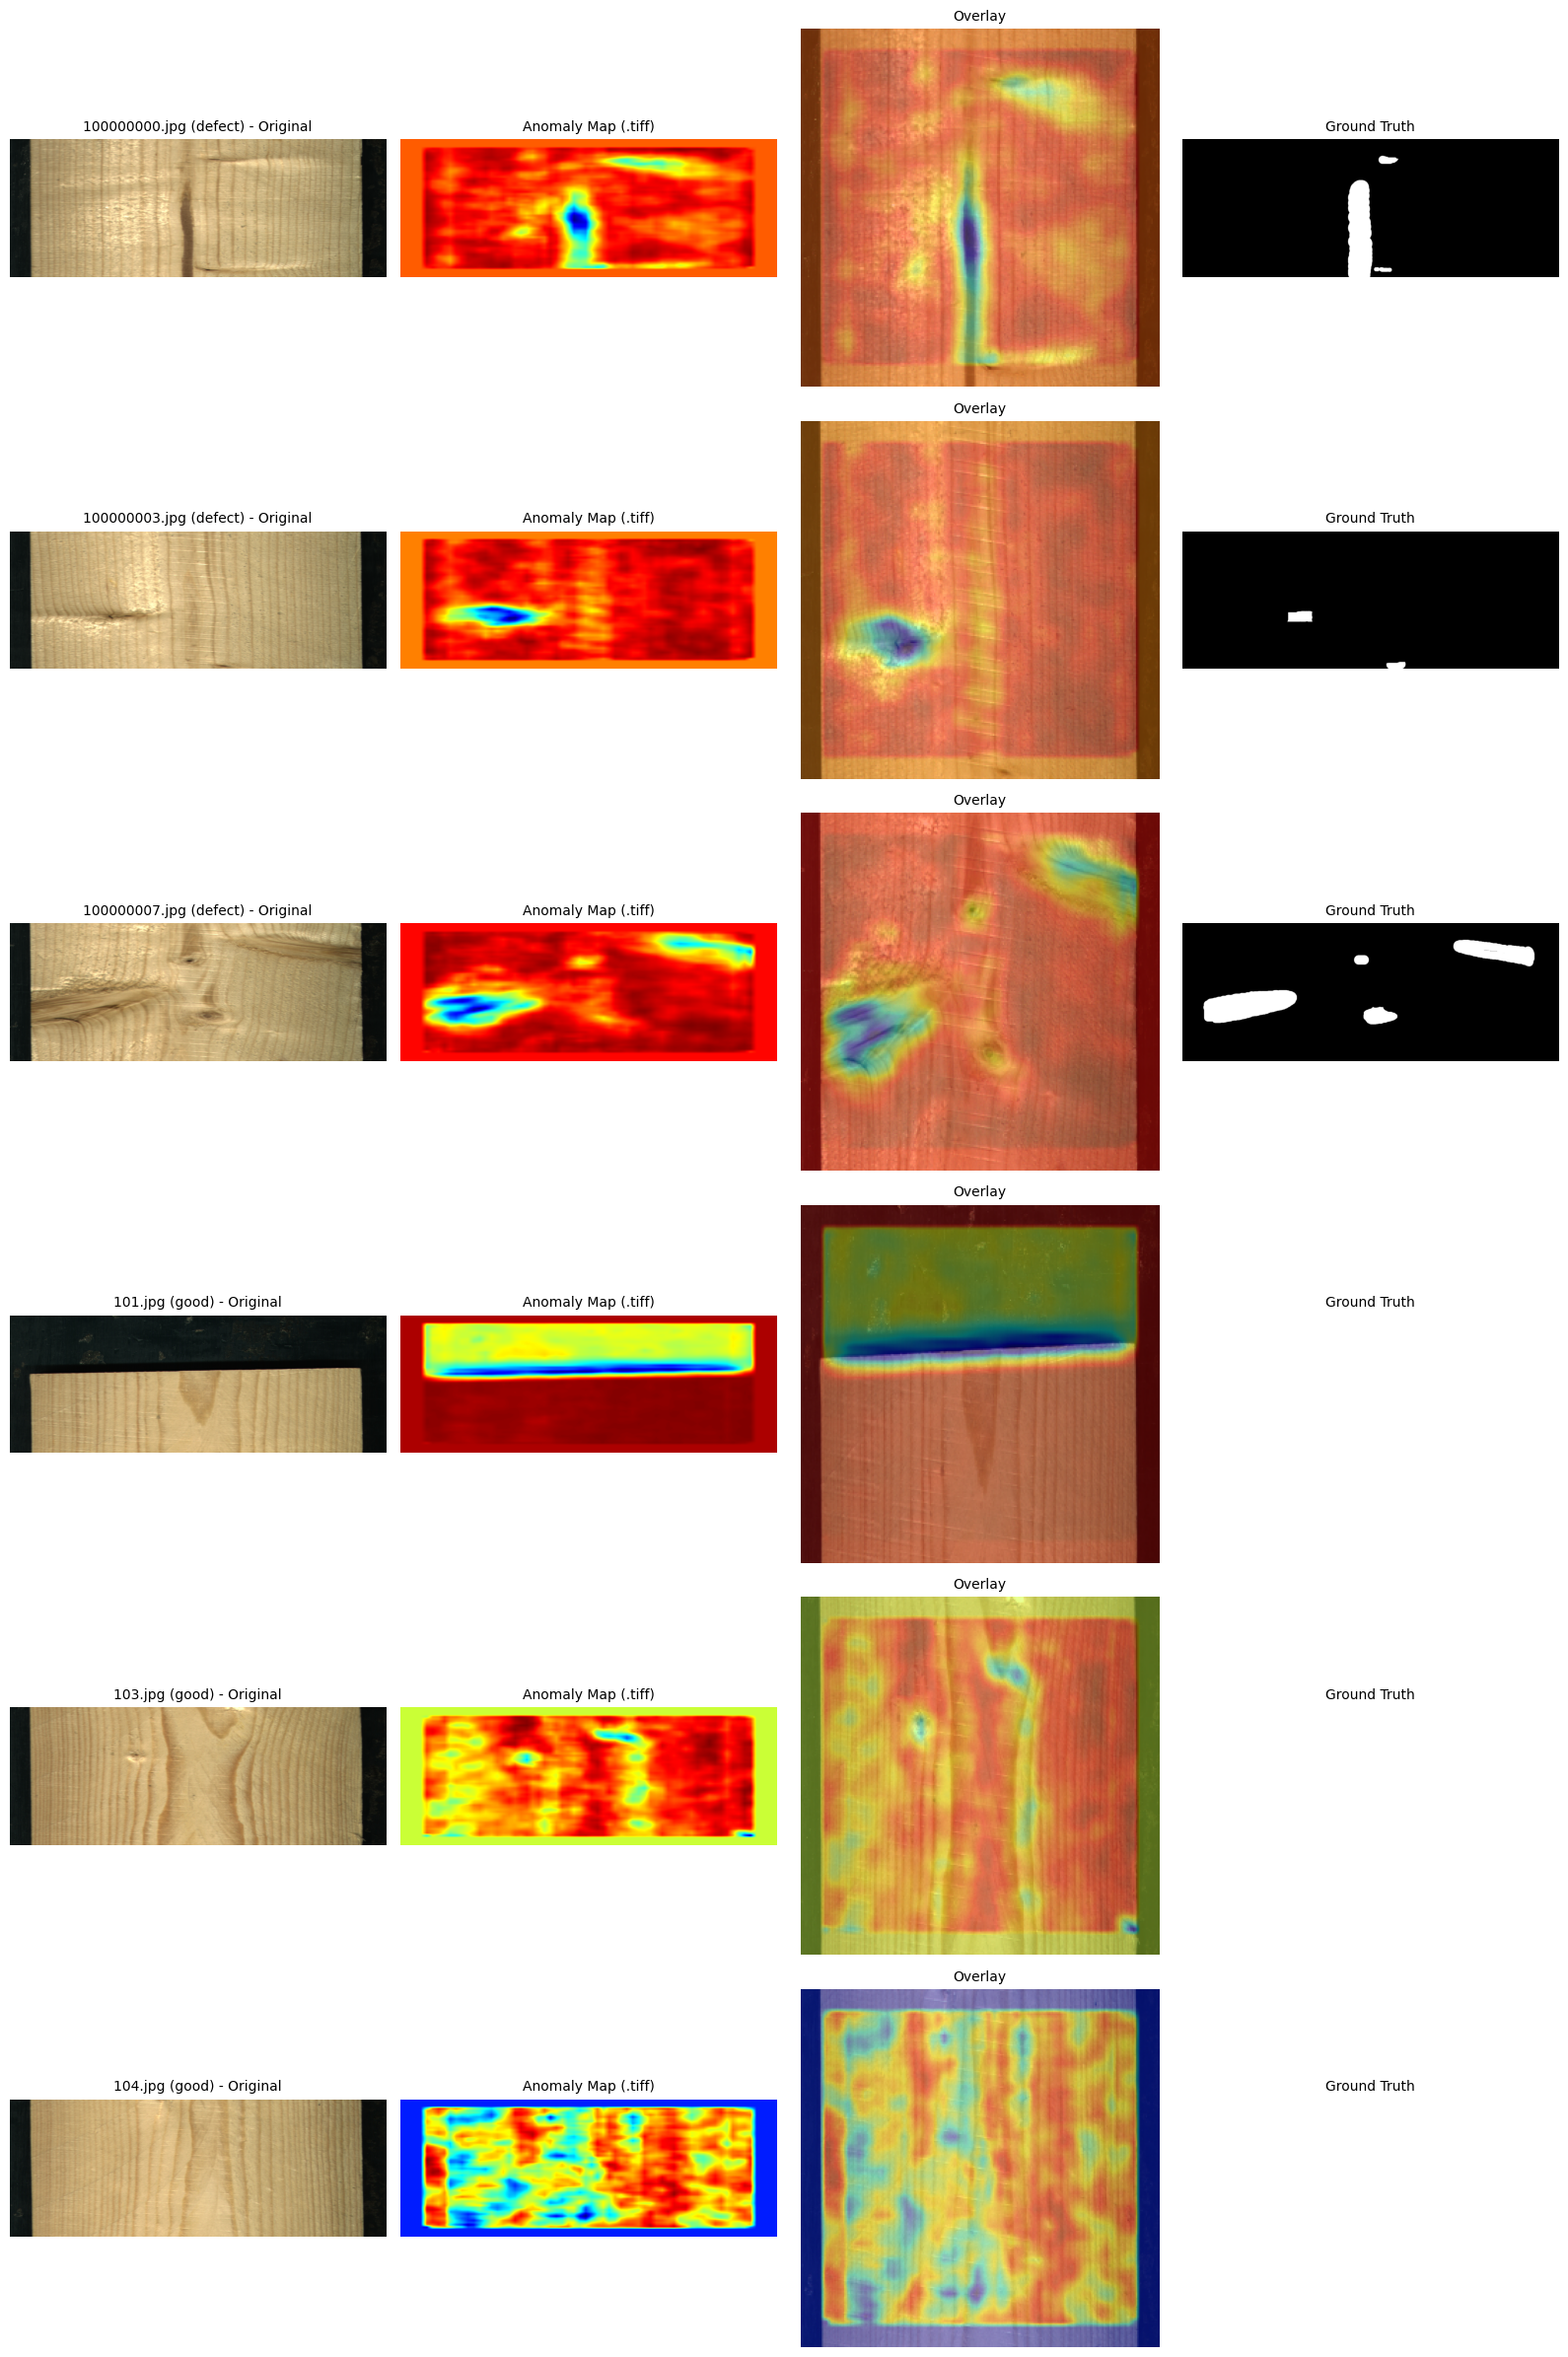

In [48]:
import matplotlib.pyplot as plt
import cv2
import os
import tifffile
import numpy as np

def show_anomaly_results(image_list,
                         dataset_root='/content/drive/MyDrive/efficient_ad/EfficientAD/mvtec_anomaly_detection/wood/test',
                         gt_root='/content/drive/MyDrive/efficient_ad/EfficientAD/mvtec_anomaly_detection/wood/ground_truth/defect',
                         output_root='/content/drive/MyDrive/efficient_ad/EfficientAD/output/1/anomaly_maps/mvtec_ad/wood/test'):

    all_images = []
    all_titles = []

    for image_name in image_list:
        image_id = image_name.split('.')[0]

        # Klasör tipi belirleme (defect/good)
        if os.path.exists(os.path.join(dataset_root, 'defect', image_name)):
            sample_type = 'defect'
        elif os.path.exists(os.path.join(dataset_root, 'good', image_name)):
            sample_type = 'good'
        else:
            print(f"{image_name} bulunamadı, atlanıyor.")
            continue

        # Orijinal Resmi Oku
        orig_path = os.path.join(dataset_root, sample_type, image_name)
        orig_img = cv2.imread(orig_path)
        orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

        # TIFF Anomaly Map Oku (sadece defect veya good için doğru klasör)
        tiff_path = os.path.join(output_root, sample_type, f"{image_id}.tiff")
        if os.path.exists(tiff_path):
            tiff_img = tifffile.imread(tiff_path)
            tiff_img = cv2.normalize(tiff_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
            tiff_img = cv2.applyColorMap(tiff_img, cv2.COLORMAP_JET)
        else:
            tiff_img = np.ones_like(orig_img) * 255  # Beyaz placeholder

        # Overlay PNG Oku
        overlay_path = os.path.join(output_root, sample_type, f"{image_id}_overlay.png")
        if os.path.exists(overlay_path):
            overlay_img = cv2.imread(overlay_path)
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)
        else:
            overlay_img = np.ones_like(orig_img) * 255  # Beyaz placeholder

        # Ground Truth (sadece defect için mevcut)
        gt_path = os.path.join(gt_root, f"{image_id}_mask.jpg")
        if os.path.exists(gt_path):
            gt_img = cv2.imread(gt_path)
            gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
        else:
            gt_img = np.ones_like(orig_img) * 255  # Beyaz placeholder

        # Görselleri ekle
        all_images.extend([orig_img, tiff_img, overlay_img, gt_img])
        all_titles.extend([
            f"{image_name} ({sample_type}) - Original",
            "Anomaly Map (.tiff)",
            "Overlay",
            "Ground Truth"
        ])

    # Grid Yapısı
    n = len(all_images) // 4
    fig, axs = plt.subplots(n, 4, figsize=(16, 4 * n))

    for i in range(n):
        for j in range(4):
            ax = axs[i][j] if n > 1 else axs[j]
            ax.imshow(all_images[i * 4 + j])
            ax.set_title(all_titles[i * 4 + j], fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# Örnek Kullanım
show_anomaly_results([
    "100000000.jpg",   # defect
    "100000003.jpg",   # defect
    "100000007.jpg",   # defect
    "101.jpg",         # good
    "103.jpg",         # good
    "104.jpg",         # good
])




In [ ]:
# tiff

### Test Hazırlık Kodu

In [16]:
import torch
import os
from common import get_autoencoder, get_pdn_small, get_pdn_medium

# Log fonksiyonu (Hata ayıklama için)
def log_message(message, level="INFO"):
    print(f"[{level}] {message}")

# Model parametreleri
out_channels = 384
model_size = "small"  # Eğer eğitimde "medium" kullandıysan bunu değiştir.

# Model dosyalarının yolları
model_paths = {
    "teacher": "output/1/trainings/mvtec_ad/wood/teacher_final.pth",
    "student": "output/1/trainings/mvtec_ad/wood/student_final.pth",
    "autoencoder": "output/1/trainings/mvtec_ad/wood/autoencoder_final.pth"
}

# Model dosyalarının var olup olmadığını kontrol et
for model_name, model_path in model_paths.items():
    if not os.path.exists(model_path):
        log_message(f"{model_name} modeli bulunamadı: {model_path}", level="ERROR")
        raise FileNotFoundError(f"{model_name} modeli eksik! {model_path} dosyasını kontrol et.")

# GPU Kullanımı (Eğer varsa)
device = "cuda" if torch.cuda.is_available() else "cpu"
log_message(f"Model {device.upper()} cihazında çalışacak.")

# Model yükleme fonksiyonu (Hata yakalama eklenmiş)
def load_model_weights(path, model_name):
    try:
        # PyTorch 2.6'daki güvenlik değişiklikleri için 'weights_only=False' açıkça belirtildi.
        state_dict = torch.load(path, map_location=device, weights_only=False)

        # Eğer model Sequential olarak kaydedilmişse
        if isinstance(state_dict, torch.nn.Sequential):
            log_message(f"{model_name} Sequential modeli olarak doğrudan yüklendi.")
            return state_dict.to(device).eval()

        # Eğer sadece state_dict kaydedilmişse
        elif isinstance(state_dict, dict):
            log_message(f"{model_name} ağırlıkları state_dict olarak yüklendi.")
            return state_dict

        else:
            log_message(f"{model_name} için beklenmeyen dosya formatı: {type(state_dict)}", level="ERROR")
            raise TypeError(f"Geçersiz model formatı: {type(state_dict)}")

    except Exception as e:
        log_message(f"{model_name} model yükleme hatası: {str(e)}", level="ERROR")
        raise e

# Modeli oluştur
try:
    if model_size == "small":
        teacher = get_pdn_small(out_channels)
        student = get_pdn_small(2 * out_channels)
    elif model_size == "medium":
        teacher = get_pdn_medium(out_channels)
        student = get_pdn_medium(2 * out_channels)
    autoencoder = get_autoencoder(out_channels)
    log_message("Modeller başarıyla oluşturuldu.")
except Exception as e:
    log_message(f"Model oluşturma hatası: {str(e)}", level="ERROR")
    raise e

# Ağırlıkları yükle
teacher_weights = load_model_weights(model_paths["teacher"], "teacher")
student_weights = load_model_weights(model_paths["student"], "student")
autoencoder_weights = load_model_weights(model_paths["autoencoder"], "autoencoder")

# Eğer state_dict() olarak yüklenmişse, modellerin içine yükle
if isinstance(teacher_weights, dict):
    teacher.load_state_dict(teacher_weights)
    teacher.to(device).eval()
if isinstance(student_weights, dict):
    student.load_state_dict(student_weights)
    student.to(device).eval()
if isinstance(autoencoder_weights, dict):
    autoencoder.load_state_dict(autoencoder_weights)
    autoencoder.to(device).eval()

log_message("Tüm modeller başarıyla yüklendi ve test için hazır!")


[INFO] Model CUDA cihazında çalışacak.
[INFO] Modeller başarıyla oluşturuldu.
[INFO] teacher Sequential modeli olarak doğrudan yüklendi.
[INFO] student Sequential modeli olarak doğrudan yüklendi.
[INFO] autoencoder Sequential modeli olarak doğrudan yüklendi.
[INFO] Tüm modeller başarıyla yüklendi ve test için hazır!


## Test 1 (No pdf)

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from torchvision import transforms
from PIL import Image
import os
import glob

# ==================== LOGGING ====================
def log_message(message, level="INFO"):
    print(f"[{level}] {message}")

# ==================== CİHAZ SEÇİMİ ====================
def get_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_message(f"Model {device.upper()} cihazında çalışacak.")
    return device

# ==================== GÖRÜNTÜ DÖNÜŞÜMÜ ====================
def get_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# ==================== MODEL YÜKLEME ====================
def load_models(device):
    import torch.serialization
    from torch.nn import Sequential

    # PyTorch 2.6 için güvenli modül olarak Sequential'ı izinli listeye ekle
    torch.serialization.add_safe_globals({'Sequential': Sequential})

    teacher_path = "output/1/trainings/mvtec_ad/wood/teacher_final.pth"
    student_path = "output/1/trainings/mvtec_ad/wood/student_final.pth"
    autoencoder_path = "output/1/trainings/mvtec_ad/wood/autoencoder_final.pth"

    for path in [teacher_path, student_path, autoencoder_path]:
        if not os.path.exists(path):
            log_message(f"Model dosyası eksik: {path}", level="ERROR")
            raise FileNotFoundError(f"Model dosyası bulunamadı: {path}")

    try:
        # weights_only=False → modeli tamamen yükle
        teacher = torch.load(teacher_path, map_location=device, weights_only=False).to(device).eval()
        student = torch.load(student_path, map_location=device, weights_only=False).to(device).eval()
        autoencoder = torch.load(autoencoder_path, map_location=device, weights_only=False).to(device).eval()
        log_message("Tüm modeller başarıyla yüklendi.")
        return teacher, student, autoencoder
    except Exception as e:
        log_message(f"Modeller yüklenemedi: {str(e)}", level="ERROR")
        raise e


# ==================== TEST GÖRÜNTÜLERİNİ YÜKLE ====================
def load_test_images(path="mvtec_ad/wood/test/*/*.png"):
    image_paths = glob.glob(path)
    if not image_paths:
        log_message("Test görüntüleri bulunamadı! Lütfen test setini kontrol et.", level="ERROR")
        raise FileNotFoundError("Test setinde görüntü bulunamadı!")
    log_message(f"{len(image_paths)} test görüntüsü bulundu. Model değerlendiriliyor...")
    return image_paths

# ==================== MODEL TESTİ ====================
def test_model(image, teacher, student, autoencoder, device):
    with torch.no_grad():
        image = image.to(device)
        teacher_output = teacher(image)
        student_output = student(image)
        _ = autoencoder(image)  # opsiyonel
        anomaly_map = torch.mean((teacher_output - student_output[:, :384]) ** 2, dim=1, keepdim=True)
        anomaly_map = torch.nn.functional.interpolate(anomaly_map, size=(256, 256), mode="bilinear")
        return anomaly_map.squeeze().cpu().numpy()

# ==================== IoU HESAPLAMA ====================
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).astype(np.uint8)
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    return intersection / union if union > 0 else 0

# ==================== MODELİ DEĞERLENDİR ====================
def evaluate_model(test_paths, teacher, student, autoencoder, device, transform):
    y_true, y_scores, ious = [], [], []

    for img_path in test_paths:
        try:
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(device)

            anomaly_map = test_model(image_tensor, teacher, student, autoencoder, device)
            y_score = np.max(anomaly_map)

            true_label = 0 if "good" in img_path else 1
            y_true.append(true_label)
            y_scores.append(y_score)

            gt_mask_path = img_path.replace("test", "ground_truth").replace(".png", "_mask.png")
            if os.path.exists(gt_mask_path):
                gt_mask = np.array(Image.open(gt_mask_path).convert("L").resize((256, 256))) > 0
                iou = calculate_iou(anomaly_map, gt_mask)
                ious.append(iou)

        except Exception as e:
            log_message(f"Hata oluştu: {img_path} - {str(e)}", level="ERROR")

    if len(y_true) == 0 or len(y_scores) == 0:
        raise ValueError("Model test verilerini işleyemedi. Lütfen model ve veri formatlarını kontrol et.")

    return y_true, y_scores, ious

# ==================== METRİK HESAPLAMA ====================
def compute_metrics(y_true, y_scores, ious):
    threshold_90 = np.percentile(y_scores, 90)
    threshold_95 = np.percentile(y_scores, 95)

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    f1_90 = f1_score(y_true, (np.array(y_scores) > threshold_90).astype(int))
    f1_95 = f1_score(y_true, (np.array(y_scores) > threshold_95).astype(int))
    f1_opt = f1_score(y_true, (np.array(y_scores) > optimal_threshold).astype(int))

    roc_auc = roc_auc_score(y_true, y_scores)
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    iou_mean = np.mean(ious) if ious else None

    return {
        "threshold_90": threshold_90,
        "threshold_95": threshold_95,
        "optimal_threshold": optimal_threshold,
        "f1_90": f1_90,
        "f1_95": f1_95,
        "f1_opt": f1_opt,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "iou_mean": iou_mean
    }

# ==================== SONUÇLARI GÖSTER ====================
def display_results(metrics, y_scores):
    log_message(f"90. Percentile Threshold: {metrics['threshold_90']:.4f}")
    log_message(f"95. Percentile Threshold: {metrics['threshold_95']:.4f}")
    log_message(f"Optimal ROC Threshold: {metrics['optimal_threshold']:.4f}")
    log_message(f"ROC-AUC: {metrics['roc_auc']:.4f}")
    log_message(f"Precision-Recall AUC: {metrics['pr_auc']:.4f}")
    log_message(f"F1 Score (90th percentile): {metrics['f1_90']:.4f}")
    log_message(f"F1 Score (95th percentile): {metrics['f1_95']:.4f}")
    log_message(f"F1 Score (Optimal ROC threshold): {metrics['f1_opt']:.4f}")
    if metrics['iou_mean'] is not None:
        log_message(f"Ortalama IoU: {metrics['iou_mean']:.4f}")

# ==================== HISTOGRAM ====================
def plot_histogram(y_scores, metrics):
    plt.figure(figsize=(10, 5))
    plt.hist(y_scores, bins=50, alpha=0.75, label="Anomaly Scores")
    plt.axvline(x=metrics['threshold_90'], color='green', linestyle="--", label=f"90th Percentile: {metrics['threshold_90']:.4f}")
    plt.axvline(x=metrics['threshold_95'], color='orange', linestyle="--", label=f"95th Percentile: {metrics['threshold_95']:.4f}")
    plt.axvline(x=metrics['optimal_threshold'], color='blue', linestyle="--", label=f"Optimal ROC Threshold: {metrics['optimal_threshold']:.4f}")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.title("Anomaly Score Distribution")
    plt.legend()
    plt.show()

# ==================== ÖRNEK GÖRÜNTÜLERİ GÖSTER ====================
def visualize_examples(test_paths, transform, teacher, student, autoencoder, device):
    sample_images = np.random.choice(test_paths, min(5, len(test_paths)), replace=False)
    for img_path in sample_images:
        try:
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(device)
            anomaly_map = test_model(image_tensor, teacher, student, autoencoder, device)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(Image.open(img_path))
            plt.title("Orijinal Görüntü")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(anomaly_map, cmap="jet")
            plt.title("Anomali Haritası")
            plt.axis("off")

            plt.show()

        except Exception as e:
            log_message(f"Görselleştirme hatası: {img_path} - {str(e)}", level="ERROR")

# ==================== ANA FONKSİYON ====================
def main():
    device = get_device()
    teacher, student, autoencoder = load_models(device)
    transform = get_transform()
    test_paths = load_test_images()

    y_true, y_scores, ious = evaluate_model(test_paths, teacher, student, autoencoder, device, transform)
    metrics = compute_metrics(y_true, y_scores, ious)

    display_results(metrics, y_scores)
    plot_histogram(y_scores, metrics)
    visualize_examples(test_paths, transform, teacher, student, autoencoder, device)

    log_message("Test tamamlandı!")

# ==================== ÇALIŞTIR ====================
if __name__ == "__main__":
    main()


[INFO] Model CUDA cihazında çalışacak.
[INFO] Tüm modeller başarıyla yüklendi.
[ERROR] Test görüntüleri bulunamadı! Lütfen test setini kontrol et.


FileNotFoundError: Test setinde görüntü bulunamadı!

## Test 2 (with pdf extension)

[INFO] Model CUDA cihazında çalışacak.
[INFO] Tüm modeller başarıyla yüklendi.
[INFO] 141 test görüntüsü bulundu. Model değerlendiriliyor...
[INFO] 90. Percentile Threshold: 2.9924
[INFO] 95. Percentile Threshold: 3.7299
[INFO] Optimal ROC Threshold: 2.1251
[INFO] ROC-AUC: 0.7996
[INFO] Precision-Recall AUC: 0.8075
[INFO] F1 Score (90th percentile): 0.2824
[INFO] F1 Score (95th percentile): 0.1795
[INFO] F1 Score (Optimal ROC threshold): 0.7368
[INFO] Ortalama IoU: 0.0333


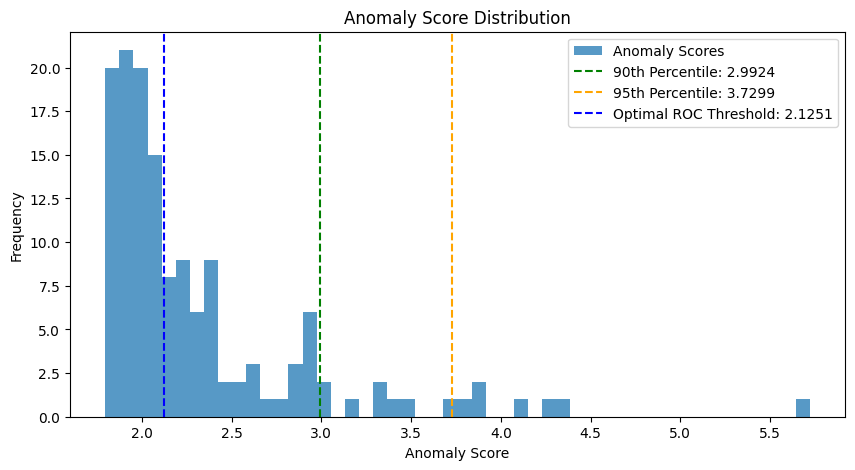

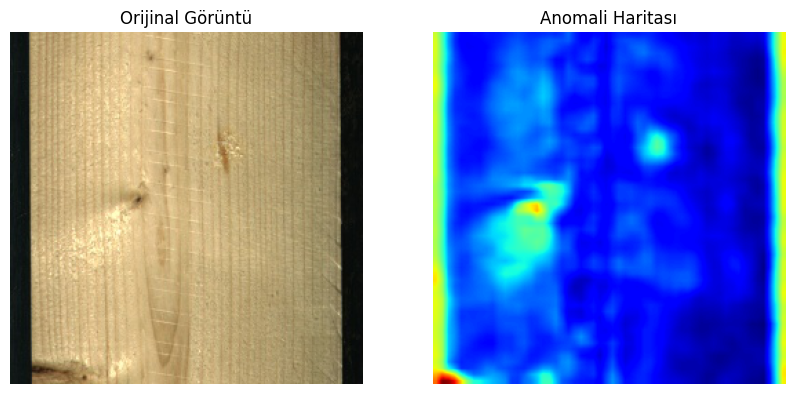

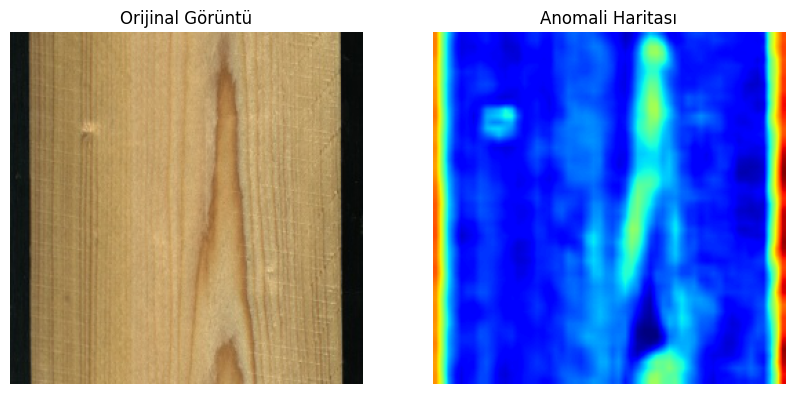

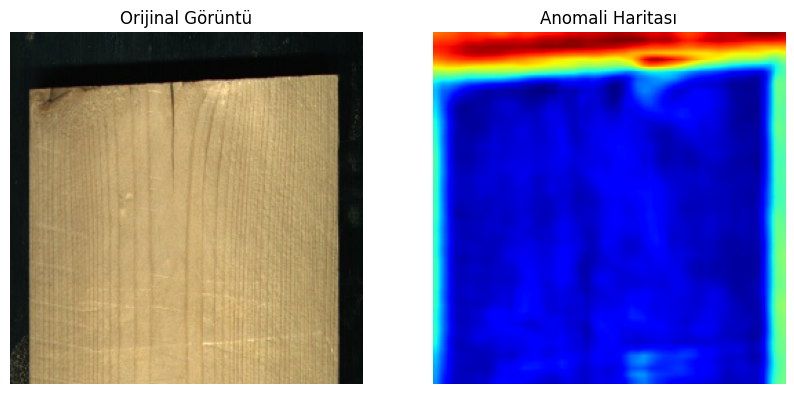

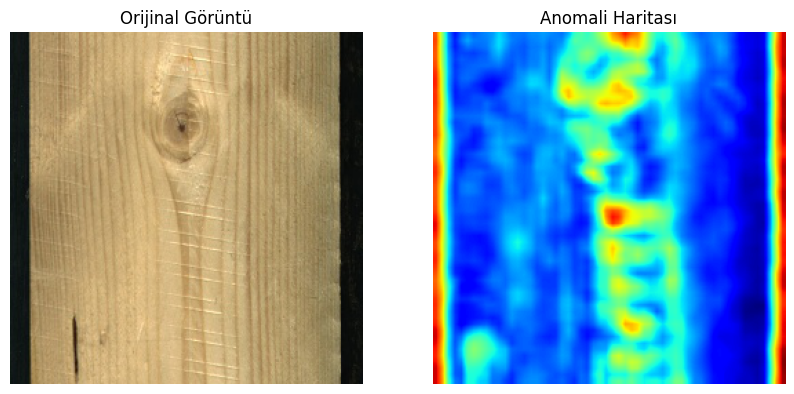

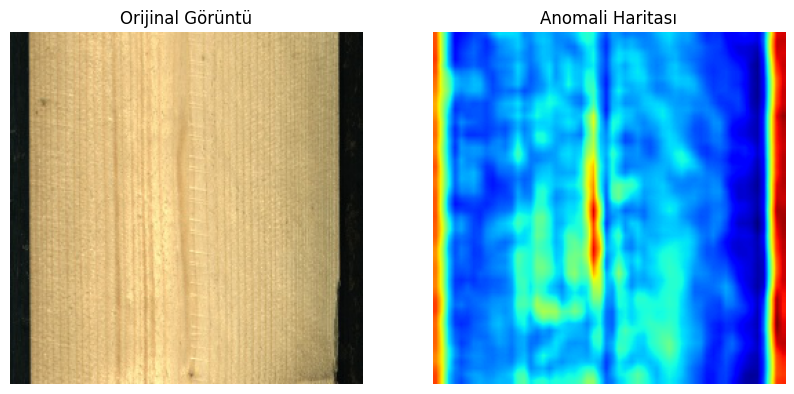

[INFO] PDF raporu oluşturuluyor...
[INFO] PDF raporu kaydedildi: pdfresults/29_03_25_09_08_50.pdf
[INFO] Test tamamlandı!


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve, auc, roc_curve
from torchvision import transforms
from PIL import Image
import os
import glob
from matplotlib.backends.backend_pdf import PdfPages  # PDF oluşturmak için
from datetime import datetime

# ==================== LOGGING ====================
def log_message(message, level="INFO"):
    print(f"[{level}] {message}")

# ==================== CİHAZ SEÇİMİ ====================
def get_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    log_message(f"Model {device.upper()} cihazında çalışacak.")
    return device

# ==================== GÖRÜNTÜ DÖNÜŞÜMÜ ====================
def get_transform():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# ==================== PDF OLUŞTURMA ====================
def save_pdf(metrics, y_scores, test_paths, transform, teacher, student, autoencoder, device, filename="results.pdf"):
    log_message("PDF raporu oluşturuluyor...")

    # 📂 PDF kaydetme klasörü
    pdf_folder = "pdfresults"
    if not os.path.exists(pdf_folder):
        os.makedirs(pdf_folder)

    timestamp = datetime.now().strftime("%d_%m_%y_%H_%M_%S")
    filename = os.path.join(pdf_folder, f"{timestamp}.pdf")



    with PdfPages(filename) as pdf:
        # **Histogram**
        plt.figure(figsize=(10, 5))
        plt.hist(y_scores, bins=50, alpha=0.75, label="Anomaly Scores")
        plt.axvline(x=metrics['threshold_90'], color='green', linestyle="--", label=f"90th Percentile: {metrics['threshold_90']:.4f}")
        plt.axvline(x=metrics['threshold_95'], color='orange', linestyle="--", label=f"95th Percentile: {metrics['threshold_95']:.4f}")
        plt.axvline(x=metrics['optimal_threshold'], color='blue', linestyle="--", label=f"Optimal ROC Threshold: {metrics['optimal_threshold']:.4f}")
        plt.xlabel("Anomaly Score")
        plt.ylabel("Frequency")
        plt.title("Anomaly Score Distribution")
        plt.legend()
        pdf.savefig()  # PDF'ye ekle
        plt.close()

        # **Örnek görüntüler ve anomaly map**
        sample_images = np.random.choice(test_paths, min(5, len(test_paths)), replace=False)
        for img_path in sample_images:
            image = Image.open(img_path).convert("RGB")
            image_tensor = transform(image).unsqueeze(0).to(device)
            anomaly_map = test_model(image_tensor, teacher, student, autoencoder, device)

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Orijinal Görüntü")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(anomaly_map, cmap="jet")
            plt.title("Anomali Haritası")
            plt.axis("off")

            pdf.savefig()  # PDF'ye ekle
            plt.close()

        # **Metin raporu**
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.axis('off')
        metin = "\n".join([
            f"90. Percentile Threshold: {metrics['threshold_90']:.4f}",
            f"95. Percentile Threshold: {metrics['threshold_95']:.4f}",
            f"Optimal ROC Threshold: {metrics['optimal_threshold']:.4f}",
            f"ROC-AUC: {metrics['roc_auc']:.4f}",
            f"Precision-Recall AUC: {metrics['pr_auc']:.4f}",
            f"F1 Score (90th percentile): {metrics['f1_90']:.4f}",
            f"F1 Score (95th percentile): {metrics['f1_95']:.4f}",
            f"F1 Score (Optimal ROC threshold): {metrics['f1_opt']:.4f}",
            f"Ortalama IoU: {metrics['iou_mean']:.4f}"
        ])
        ax.text(0.1, 0.5, metin, fontsize=12, verticalalignment="center")
        pdf.savefig()
        plt.close()

    log_message(f"PDF raporu kaydedildi: {filename}")

# ==================== MODEL YÜKLEME ====================
def load_models(device):
    teacher_path = "output/1/trainings/mvtec_anomaly_detection/wood/teacher_final.pth"
    student_path = "output/1/trainings/mvtec_anomaly_detection/wood/student_final.pth"
    autoencoder_path = "output/1/trainings/mvtec_anomaly_detection/wood/autoencoder_final.pth"

    for path in [teacher_path, student_path, autoencoder_path]:
        if not os.path.exists(path):
            print(path)
            log_message(f"Model dosyası eksik: {path}", level="ERROR")
            raise FileNotFoundError(f"Model dosyası bulunamadı: {path}")

    try:
        teacher = torch.load(teacher_path, map_location=device, weights_only=False).to(device).eval()
        student = torch.load(student_path, map_location=device, weights_only=False).to(device).eval()
        autoencoder = torch.load(autoencoder_path, map_location=device, weights_only=False).to(device).eval()
        log_message("Tüm modeller başarıyla yüklendi.")
        return teacher, student, autoencoder
    except Exception as e:
        log_message(f"Modeller yüklenemedi: {str(e)}", level="ERROR")
        raise e

# ==================== MODEL TESTİ ====================
def test_model(image, teacher, student, autoencoder, device):
    with torch.no_grad():
        image = image.to(device)
        teacher_output = teacher(image)
        student_output = student(image)
        _ = autoencoder(image)
        anomaly_map = torch.mean((teacher_output - student_output[:, :384]) ** 2, dim=1, keepdim=True)
        anomaly_map = torch.nn.functional.interpolate(anomaly_map, size=(256, 256), mode="bilinear")
        return anomaly_map.squeeze().cpu().numpy()

# ==================== ANA FONKSİYON ====================
def main():
    give_pdf = True  # Eğer True yapılırsa PDF oluşturulur

    device = get_device()
    teacher, student, autoencoder = load_models(device)
    transform = get_transform()
    test_paths = load_test_images()

    y_true, y_scores, ious = evaluate_model(test_paths, teacher, student, autoencoder, device, transform)
    metrics = compute_metrics(y_true, y_scores, ious)

    display_results(metrics, y_scores)
    plot_histogram(y_scores, metrics)
    visualize_examples(test_paths, transform, teacher, student, autoencoder, device)

    if give_pdf:
        save_pdf(metrics, y_scores, test_paths, transform, teacher, student, autoencoder, device)

    log_message("Test tamamlandı!")

# ==================== ÇALIŞTIR ====================
if __name__ == "__main__":
    main()
